In [5]:
# Importeer benodigde libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

# ================================
# 1. Data Voorbereiding
# ================================

# Laad de data
X_train = pd.read_csv('alle_kranten_X_train.csv')  # Laad trainingskenmerken
X_test = pd.read_csv('alle_kranten_X_test.csv')    # Laad testkenmerken
y_train = pd.read_csv('alle_kranten_y_train.csv')  # Laad trainingsdoelvariabele
y_test = pd.read_csv('alle_kranten_y_test.csv')    # Laad testdoelvariabele

# Controleer de vormen van de data
print(f"Train X shape: {X_train.shape}, Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}, Test y shape: {y_test.shape}")

# Clip de data
# Voor features (X_train en X_test)
X_train_clipped = np.clip(X_train, -500, 500)  # Beperk waarden tussen -500 en 500
X_test_clipped = np.clip(X_test, -500, 500)    # Beperk waarden tussen -500 en 500

# Voor doelvariabele (y_train en y_test)
y_train_clipped = np.clip(y_train, 1, None)    # Zorg ervoor dat er geen waarden kleiner dan 1 zijn
y_test_clipped = np.clip(y_test, 1, None)      # Zorg ervoor dat er geen waarden kleiner dan 1 zijn

# Log-transformatie met squeeze()
y_train_log = np.log1p(y_train_clipped.squeeze())  # Gebruik squeeze() om dimensies te verwijderen
y_test_log = np.log1p(y_test_clipped.squeeze())    # Gebruik squeeze() om dimensies te verwijderen

# Schaal de kenmerken (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_clipped)
X_test_scaled = scaler_X.transform(X_test_clipped)

# Controleer de geschaalde data
print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train_log shape: {y_train_log.shape}")

# ================================
# 2. Neural Network Model
# ================================

# Bouw het neuraal netwerk model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Inputlaag
    Dense(512, activation='relu'),           # Verborgen laag 1
    Dropout(0.3),                            # Dropout
    Dense(256, activation='relu'),           # Verborgen laag 2
    Dropout(0.2),                            # Dropout
    Dense(128, activation='relu'),           # Verborgen laag 3
    Dense(64, activation='relu'),            # Verborgen laag 4
    Dense(32, activation='relu'),            # Verborgen laag 5
    Dense(1)                                 # Outputlaag (regressie)
])

# Compile het model
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae', 'mse'])

# ================================
# 3. Modeltraining
# ================================

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train het model
history = model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),  # Gebruik testdata voor validatie
    epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1
)


Train X shape: (170772, 177), Train y shape: (170772, 1)
Test X shape: (42694, 177), Test y shape: (42694, 1)
X_train_scaled shape: (170772, 177), y_train_log shape: (170772,)
Epoch 1/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 0.2382 - mae: 0.5386 - mse: 0.6220 - val_loss: 0.1744 - val_mae: 0.4422 - val_mse: 0.3873
Epoch 2/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 0.1686 - mae: 0.4409 - mse: 0.3700 - val_loss: 0.1690 - val_mae: 0.4361 - val_mse: 0.3738
Epoch 3/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 86s 10ms/step - loss: 0.1645 - mae: 0.4343 - mse: 0.3622 - val_loss: 0.1661 - val_mae: 0.4316 - val_mse: 0.3665
Epoch 4/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - loss: 0.1617 - mae: 0.4298 - mse: 0.3558 - val_loss: 0.1683 - val_mae: 0.4337 - val_mse: 0.3721
Epoch 5/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.1596 - mae: 0.4265 - mse: 0.3497 - val_loss: 0.1638 - val_mae: 0.4326 - val_mse: 0.3604
Epoch 6/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - l

In [6]:
# ================================
# 4. Evaluatie
# ================================

# Maak voorspellingen
y_pred_log = model.predict(X_test_scaled)  # Voorspellingen op log-schaal
y_pred = np.expm1(y_pred_log)              # Inverse log-transformatie
y_test_original = np.expm1(y_test_log)     # Inverse log-transformatie van testdoelvariabele

# Bereken RMSE en R² op originele schaal
rmse = sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE op originele schaal: {rmse}")
print(f"R²-score: {r2}")

1335/1335 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
RMSE op originele schaal: 46.36740772191426
R²-score: 0.2619250737454727


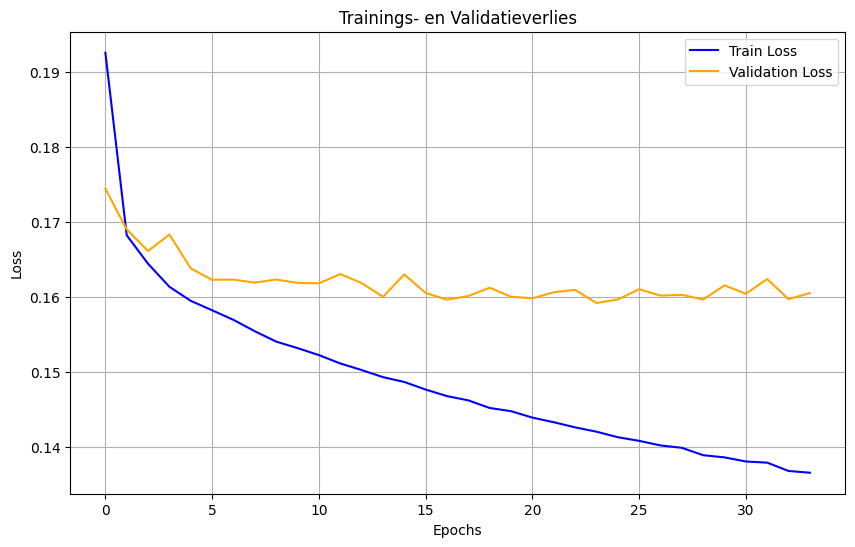

In [7]:
# ================================
# 5. Visualisaties
# ================================

# Plot trainingsgeschiedenis (Train Loss vs Validation Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Trainings- en Validatieverlies')
plt.legend()
plt.grid()
plt.show()

Top-10 belangrijkste features:
                 Feature  Importance
3             author_ids    0.266908
176   subsections_labels    0.120412
4           main_section    0.027254
0                  brand    0.022118
21               help_me    0.018292
23   hou_me_op_de_hoogte    0.017724
35                 sport    0.014282
20    raak_me_verbind_me    0.012680
52    lokale_evenementen    0.012494
30       eten_en_drinken    0.012365


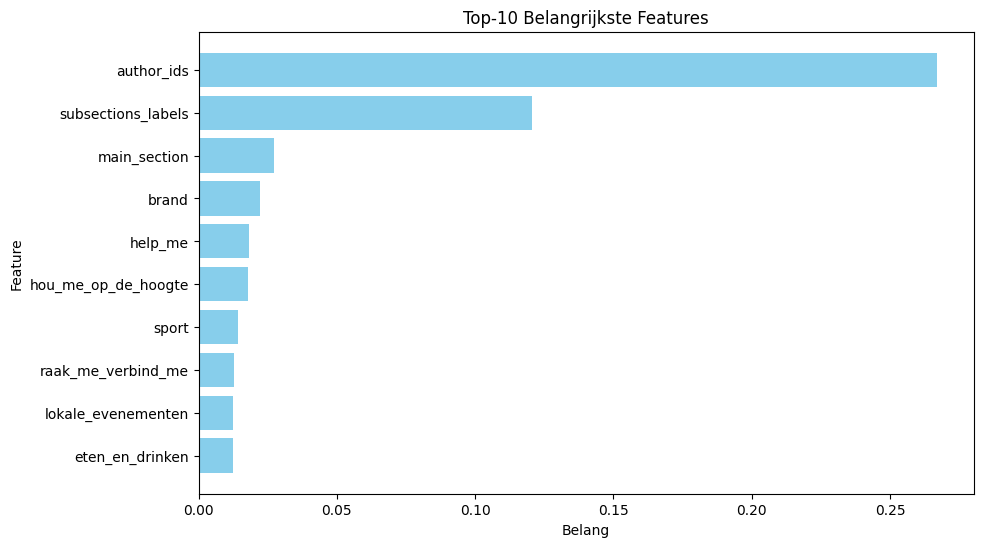

In [8]:
# Importeer benodigde libraries voor feature importance
from sklearn.ensemble import RandomForestRegressor

# ================================
# Feature Importance Analyse
# ================================

# Train een Random Forest Regressor voor Feature Importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_log)  # Train met dezelfde geschaalde data als het neural network

# Bereken feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Combineer de feature importances met de namen
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print de top-10 belangrijkste features
print("Top-10 belangrijkste features:")
print(importance_df.head(10))

# Visualiseer de top-10 belangrijkste features
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Belang')
plt.ylabel('Feature')
plt.title('Top-10 Belangrijkste Features')
plt.gca().invert_yaxis()  # Draai de y-as zodat de belangrijkste bovenaan staat
plt.show()


In [9]:
!pip install keras_tuner

In [10]:
from keras_tuner import RandomSearch

# ================================
# 6. RandomSearch Hyperparameter Optimalisatie met Aantal Lagen
# ================================

# Bouw een model voor RandomSearch
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],))  # Inputlaag
    ])

    # Voeg een variabel aantal lagen toe
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):  # Tune het aantal lagen
        model.add(Dense(
            hp.Int(f'units_{i+1}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(Dropout(
            hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.5, step=0.1)
        ))

    model.add(Dense(1))  # Outputlaag
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss=Huber(),
        metrics=['mae', 'mse']
    )
    return model

# Stel RandomSearch in
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Aantal hyperparametercombinaties
    executions_per_trial=1,  # Gemiddelde van meerdere runs
    directory='hyperparameter_tuning',
    project_name='regressie_model'
)

# Zoek naar de beste hyperparameters
tuner.search(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Haal de beste hyperparameters op
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste hyperparameters: {best_hps.values}")

# Bouw en train het beste model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_test_scaled, y_test_log),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Trial 5 Complete [00h 14m 55s]
val_loss: 0.3209564685821533

Best val_loss So Far: 0.1616908758878708
Total elapsed time: 01h 44m 10s
Beste hyperparameters: {'num_layers': 5, 'units_1': 320, 'dropout_1': 0.1, 'learning_rate': 0.001, 'units_2': 64, 'dropout_2': 0.1, 'units_3': 64, 'dropout_3': 0.1, 'units_4': 64, 'dropout_4': 0.1, 'units_5': 64, 'dropout_5': 0.1}
Epoch 1/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2726 - mae: 0.5839 - mse: 0.7411 - val_loss: 0.1694 - val_mae: 0.4404 - val_mse: 0.3734
Epoch 2/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.1796 - mae: 0.4601 - mse: 0.3958 - val_loss: 0.1689 - val_mae: 0.4370 - val_mse: 0.3722
Epoch 3/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.1723 - mae: 0.4480 - mse: 0.3801 - val_loss: 0.1679 - val_mae: 0.4404 - val_mse: 0.3674
Epoch 4/50
5337/5337 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.1665 - mae: 0.4387 - mse: 0.3668 - val_loss: 0.1678 - val_mae: 0.4342 - val_mse: 0.3712
Epoch 5/50
5337/5337 ━━

In [3]:
# ================================
# 7. Evaluatie van het Beste Model
# ================================

# Maak voorspellingen
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
rmse = sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print(f"Beste model RMSE op originele schaal: {rmse}")
print(f"Beste model R²-score: {r2}")

# Plot trainingsgeschiedenis
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Trainings- en Validatieverlies na Optimalisatie')
plt.legend()
plt.grid()
plt.show()

NameError: name 'best_model' is not defined

In [1]:
# Importeer benodigde libraries voor feature importance
from sklearn.ensemble import RandomForestRegressor

# ================================
# Feature Importance Analyse
# ================================

# Train een Random Forest Regressor voor Feature Importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_log)  # Train met dezelfde geschaalde data als het neural network

# Bereken feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Combineer de feature importances met de namen
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print de top-10 belangrijkste features
print("Top-10 belangrijkste features:")
print(importance_df.head(10))

# Visualiseer de top-10 belangrijkste features
top_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Belang')
plt.ylabel('Feature')
plt.title('Top-10 Belangrijkste Features')
plt.gca().invert_yaxis()  # Draai de y-as zodat de belangrijkste bovenaan staat
plt.show()


NameError: name 'X_train_scaled' is not defined